In [13]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import imutils
import math
from collections import defaultdict

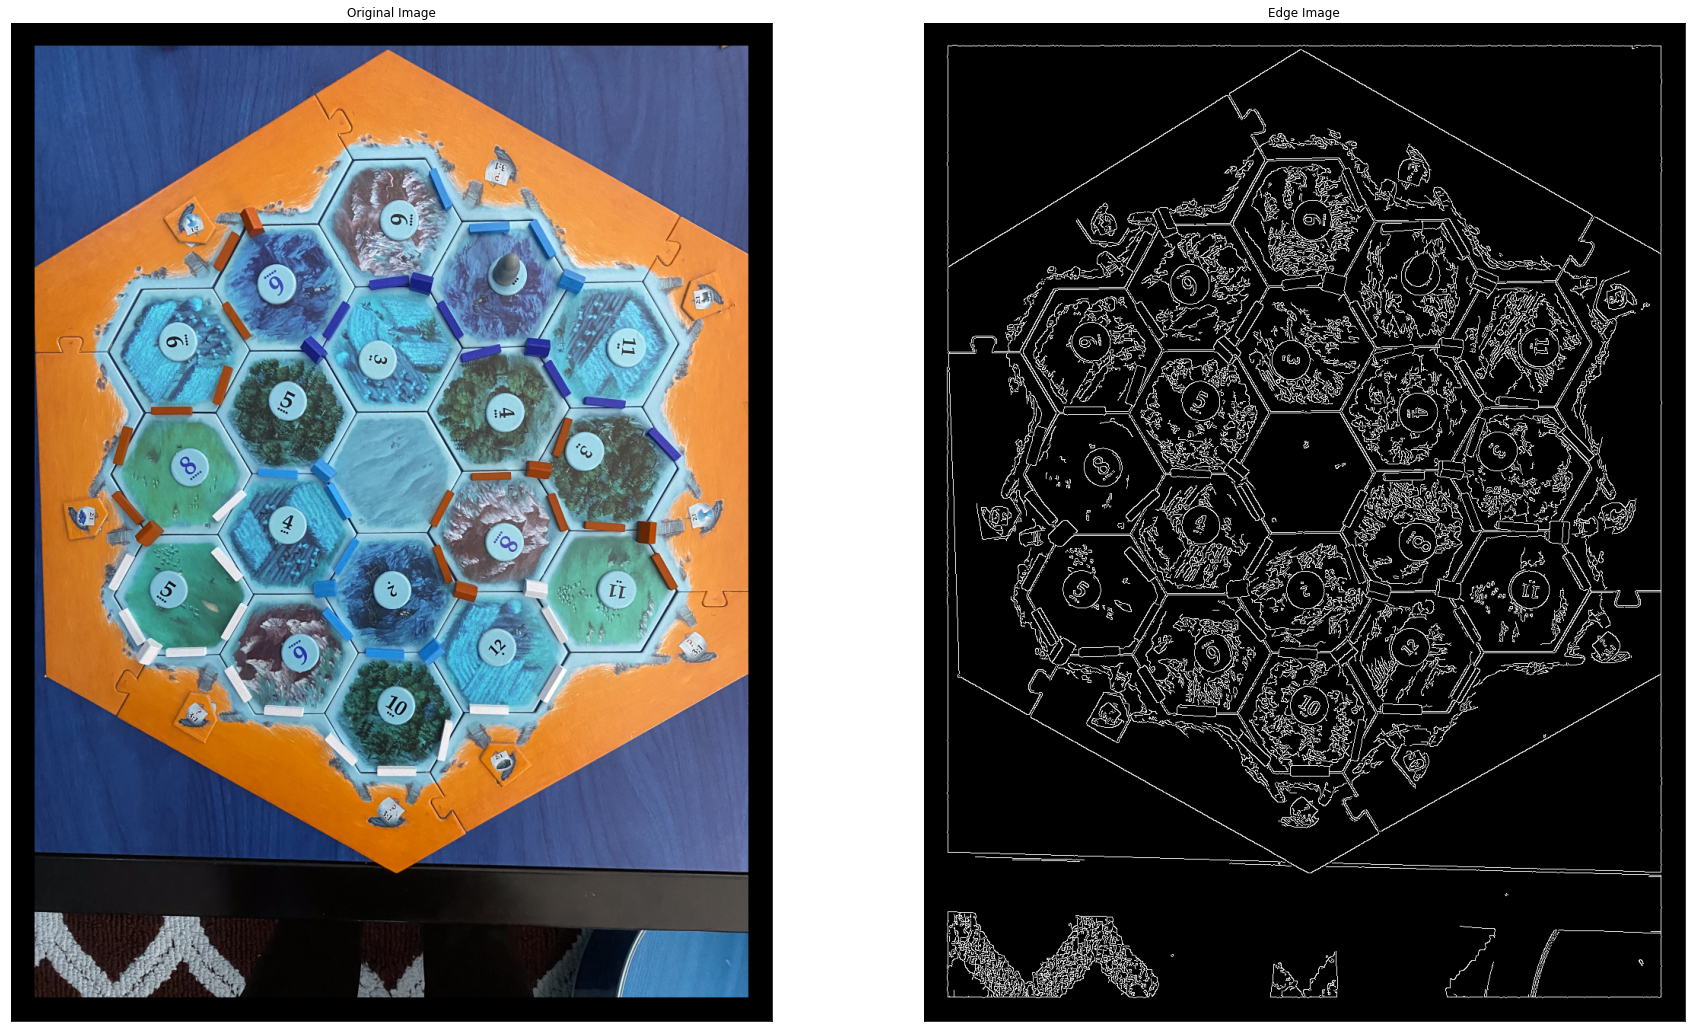

In [14]:
############################################
# Read image and get canny edge detection
############################################

# read img
img = cv.imread('photos/IMG_7864.png')[:,:,::-1]
img = cv.imread('photos/testimg2.jpg')[:,:,::-1]
pad_size = 100
img = cv.copyMakeBorder(img,pad_size, pad_size, pad_size, pad_size,cv.BORDER_CONSTANT,value=(0, 0, 0))
img = imutils.resize(img, width=1000)
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# get canny
edges = cv.Canny(img,100,300)

# see img
plt.figure(figsize=(30, 30))
plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

([], [])

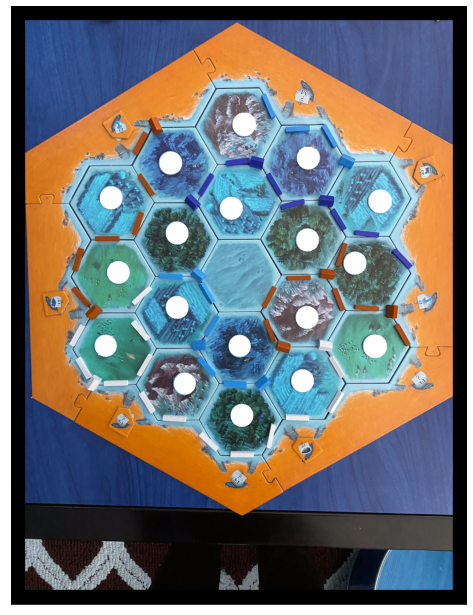

In [15]:
############################################
# get each number circle
############################################

circles = cv.HoughCircles(img_gray,cv.HOUGH_GRADIENT_ALT,1,20,
                            param1=50,param2=.92,minRadius=10,maxRadius=50)
circles = np.uint16(np.around(circles))[0,:,0:3]
circles_img = img.copy()
for circ in circles:
    cv.circle(circles_img,(circ[0],circ[1]),circ[2],(255,255,255),-1)
plt.figure(figsize=(11,11))
plt.imshow(circles_img)
plt.xticks([])
plt.yticks([])

163.48289344904595


([], [])

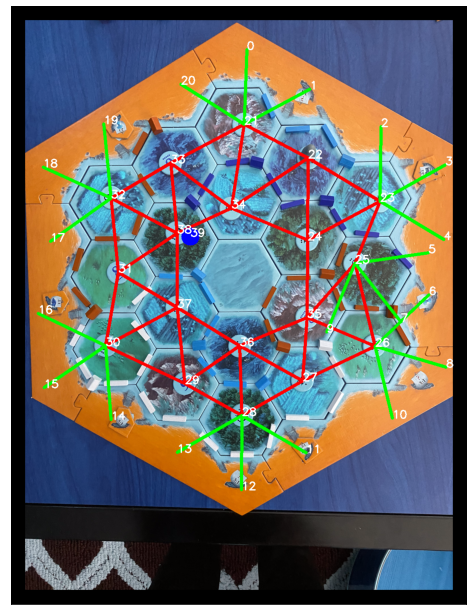

In [16]:
#########################
# get average distance
#########################

num_short_distances = 3 * 6 + 4 * 6 + 6 * 5
all_distances = []

circles = np.array(circles, dtype=np.float64)
def distanceBetweenCircles(c1, c2):
    return math.sqrt(((c1[0] - c2[0]) ** 2) + ((c1[1] - c2[1]) ** 2))

for i in range(len(circles)):
    for j in range(len(circles)):
        if (i != j):
            all_distances.append(distanceBetweenCircles(circles[i], circles[j]))

all_distances.sort()


short_distances_sum = 0
for i in range(num_short_distances):
    short_distances_sum += all_distances[i]

average_distance = short_distances_sum / num_short_distances
print(average_distance)
distance_range = 45

img_copy = img.copy()
circles_map = defaultdict(list)
for i in range(len(circles)):
    for j in range(len(circles)):
        if (distanceBetweenCircles(circles[i], circles[j]) >= average_distance - distance_range and distanceBetweenCircles(circles[i], circles[j]) <= average_distance + distance_range):
            circles_map[i].append(j)
            cv.line(img_copy, (int(circles[i][0]), int(circles[i][1])), (int(circles[j][0]), int(circles[j][1])), (255, 0, 0), 5)

def angleBetweenCircles(c1, c2):
    delta_x = c2[0] - c1[0]
    delta_y = c2[1] - c1[1]
    return math.atan2(delta_y, delta_x)

# get outer circles
outer_circles = []
inner_circles = []
outer_real_circles = []
current_outer_circle = None
top_most_outer_y = 9999
top_most_outer_real_y = 9999
top_most_inner_y = 9999
for key in circles_map:
    val = circles_map[key]
    if (len(val) == 3):
        cur_angles = []
        for other_c in val:
            cur_angles.append((math.pi * 2) + angleBetweenCircles(circles[key], circles[other_c]))
        cur_angles.sort()
        if (cur_angles[1] - cur_angles[0] - (math.pi / 6) > 1):
            cur_angles[0] += (math.pi * 2)
        if (cur_angles[2] - cur_angles[1] - (math.pi / 6) > 1):
            cur_angles[2] -= (math.pi * 2)
        cur_angles.sort()
        
        # add other angles
        maxAngle = cur_angles[2]
        for i in range(3):
            maxAngle += math.pi / 3
            newX = circles[key][0] + (average_distance * math.cos(maxAngle))
            newY = circles[key][1] + (average_distance * math.sin(maxAngle))
            cv.line(img_copy, (int(circles[key][0]), int(circles[key][1])), (int(newX), int(newY)), (0, 255, 0), 5)
            outer_circles.append([newX, newY])
            top_most_outer_y = min(top_most_outer_y, newY)
            if (i == 1):
                current_outer_circle = [newX, newY]
            if (i == 0):
                next_outer_circle = [newX, newY]

    elif (len(val) == 5):
        inner_circles.append(circles[key])
        top_most_inner_y = min(top_most_inner_y, circles[key][1])
    
    if (len(val) != 5):
        outer_real_circles.append(circles[key])
        top_most_outer_real_y = min(top_most_outer_real_y, circles[key][1])

# get center circle
average_inner_x = 0
average_inner_y = 0
for c in inner_circles:
    average_inner_x += c[0]
    average_inner_y += c[1]
average_inner_x /= 6
average_inner_y /= 6

center_circle = [average_inner_x, average_inner_y]

cv.circle(img_copy, (int(average_inner_x), int(average_inner_y)), 20, (0, 0, 255), -1)

# number
def sort_circles(c):
  return angleBetweenCircles(c, center_circle)

cars = ['Ford', 'Mitsubishi', 'BMW', 'VW']

# find top most outer circle
outer_circles.sort(key=sort_circles)
top_most_outer_y_index = 0
num_outer_circles = len(outer_circles)
for i in range(len(outer_circles)):
    cur_c = outer_circles[i]
    if (cur_c[1] == top_most_outer_y):
        top_most_outer_y_index = i
        break
outer_circles += outer_circles

# find top most outer real circle
outer_real_circles.sort(key=sort_circles)
top_most_outer_real_y_index = 0
num_outer_real_circles = len(outer_real_circles)
for i in range(len(outer_real_circles)):
    cur_c = outer_real_circles[i]
    if (cur_c[1] == top_most_outer_real_y):
        top_most_outer_real_y_index = i
        break
outer_real_circles += outer_real_circles

# find top most inner circles
inner_circles.sort(key=sort_circles)
top_most_inner_y_index = 0
num_inner_circles = len(inner_circles)
for i in range(len(inner_circles)):
    cur_c = inner_circles[i]
    if (cur_c[1] == top_most_inner_y):
        top_most_inner_y_index = i
        break
inner_circles += inner_circles


points = []
point_num = 0
for i in range(top_most_outer_y_index, top_most_outer_y_index + num_outer_circles):
    cur_c = outer_circles[i]
    # cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])

for i in range(top_most_outer_real_y_index, top_most_outer_real_y_index + num_outer_real_circles):
    cur_c = outer_real_circles[i]
    #cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])
    
for i in range(top_most_inner_y_index, top_most_inner_y_index + num_inner_circles):
    cur_c = inner_circles[i]
    # cv.putText(img_copy, str(point_num), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
    point_num += 1
    points.append([cur_c[0], cur_c[1]])


# cv.putText(img_copy, str(point_num), (int(center_circle[0]), int(center_circle[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)
points.append([center_circle[0], center_circle[1]])

for i in range(len(points)):
    cur_c = points[i]
    cv.putText(img_copy, str(i), (int(cur_c[0]), int(cur_c[1])), cv.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 255), 2)

plt.figure(figsize=(11,11))
plt.imshow(img_copy)
plt.xticks([])
plt.yticks([])


